In [5]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from superposition_theorem import *
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param,backend=backend)


/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/pyth

# compute the A matrix that defines the delta

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

In [6]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [7]:
init_obs

In [8]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [9]:
A = (all_flows - F) / F.reshape(-1, 1)

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/3487405670.py:1: RuntimeWarning: divide by zero encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)
/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/3487405670.py:1: RuntimeWarning: invalid value encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)


In [10]:
F

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

In [11]:
A[3][3]

-1.0

In [12]:
init_obs.p_or[2] + A[1, 2] * init_obs.p_or[1]

28.917064666748047

In [13]:
all_flows[1, 2]

28.917064666748047

In [14]:
all_flows[1]

array([ 76.19999695,   0.        ,  28.91706467,  54.98823929,
        53.09469223,  23.21706772, -11.00502491,   5.76739502,
         6.9721899 ,  15.95008183,   6.43260527,   9.9777298 ,
        -2.36739492,   1.47218966,   4.82227087,  28.17004204,
        16.44029236,  35.18966675,   0.        , -28.17004204])

In [15]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/1743600663.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


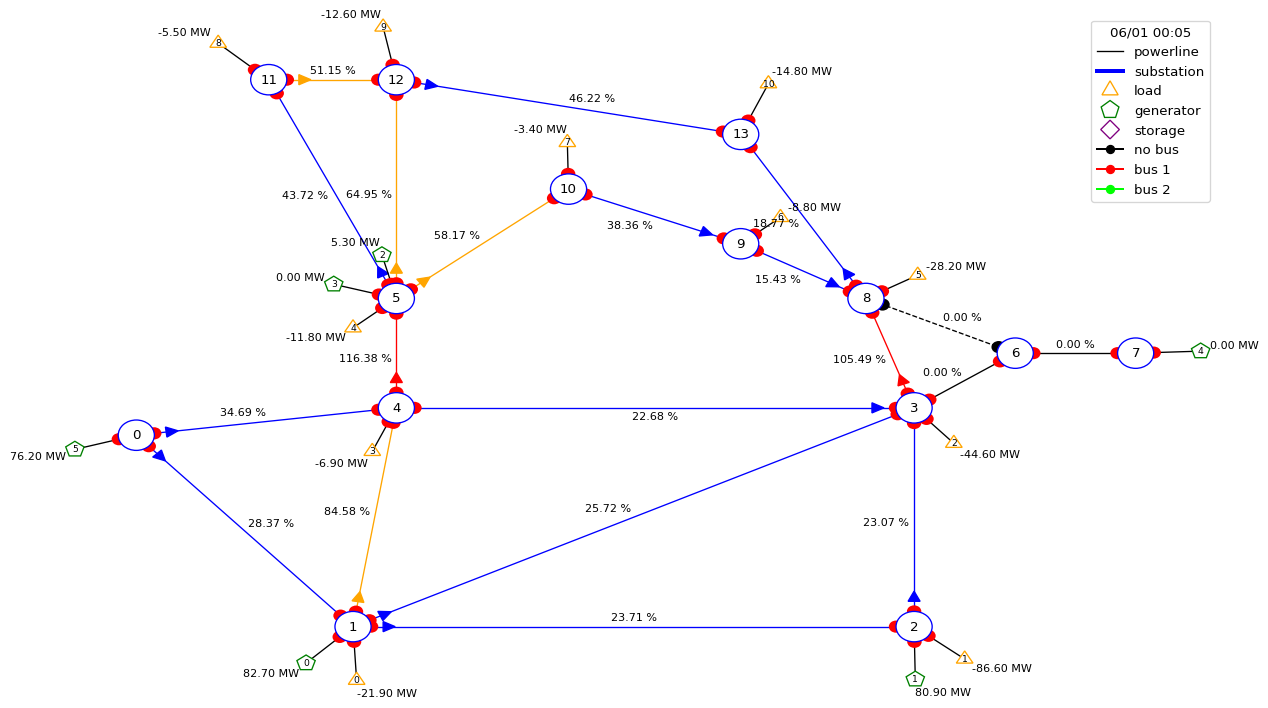

In [16]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()


In [17]:
id_l1=3
id_l2=7
id_l3=0
#with env.copy() as tmp_env:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

## compute virtual flows for disconnections without using LODF


### compute Equivalent Resistance Matrix to see if we can use it to deduce virtual flows

In [18]:
YBus=env.backend._grid.get_dcYbus().todense()

In [19]:
pinv_Bbus=np.linalg.pinv(YBus)
n_nodes=pinv_Bbus.shape[0]
R_eq=np.array([[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

### Scenario 1: disconnecting 1 line and assessing virtual flow - easy scenario

In [20]:
#lines to disconnect
[id_l1,id_l2,id_l3]


[3, 7, 0]

In [21]:
# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2,id_l3])
p_end

[31.48895452  7.69634534 30.28299473]


array([ 4.8924323e-07,  7.6199997e+01,  2.6675289e+01, -3.9898677e-07,
        3.4124710e+01,  2.0975294e+01, -6.9691467e+01, -5.6055299e-08,
        7.9306002e+00,  1.9302643e+01,  1.2200000e+01,  5.6667576e+00,
        3.4000001e+00,  2.4306002e+00,  9.1332417e+00,  2.9089725e+01,
        1.6977028e+01,  3.3733246e+01,  0.0000000e+00, -2.9089725e+01],
      dtype=float32)

In [22]:
init_obs.p_or[[id_l1,id_l2,id_l3]]

array([41.696144 ,  6.4211507, 38.58359  ], dtype=float32)

#### check that we compute flows properly with thetas

In [23]:
theta_or=init_obs.theta_or
theta_ex=init_obs.theta_ex
print(theta_or)
print(theta_ex)

v_or=init_obs.v_or
v_ex=init_obs.v_or

sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
sub_l1_or=init_obs.line_or_to_subid[id_l1]
#lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
#lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
sub_l2_or=init_obs.line_or_to_subid[id_l2]
#lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
#lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])


delta_theta_l1=theta_or[id_l1]-theta_ex[id_l1]
delta_theta_l2=theta_or[id_l2]-theta_ex[id_l2]
print(delta_theta_l1)
print(delta_theta_l2)

virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex])*delta_theta_l1/360*2*3.14159*100
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex])*delta_theta_l2/360*2*3.14159*100
print(virtual_flow_l1)
print(virtual_flow_l2)

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

[  0.          0.         -1.3080575  -1.3080575  -1.3080575  -3.8676474
  -5.5203657  -9.68895    -9.68895    -9.68895   -10.473401  -10.473401
 -10.753183  -10.724925  -10.904521   -5.5203657  -5.5203657  -4.807095
  -8.741024  -10.473401 ]
[ -1.3080575  -4.807095   -3.8676474  -5.5203657  -4.807095   -5.5203657
  -4.807095  -10.420712  -10.724925  -10.904521  -10.753183  -11.952206
 -10.420712  -10.904521  -11.952206   -8.741024  -10.473401   -9.68895
  -8.741024   -8.741024 ]
4.212308
0.7317629
41.696109566525784
6.4211467660397075


#### now computing on a state with a disconneted line l1 (id=3)

Explication: lorsque la ligne est deconnectee, un flux virtual_flow_NorNexl1_wo_l1 circule entre ces deux noeuds extremites etant donne les differences de potentiel et une resistance equivalente Req_l_line_disco.

Pour obtenir un modèle équivalent en reconnectant l1, il faut que ce flux global soit conservé entre ces 2 noeuds.
En reconnectant l1, le dit flux se réparti entre la ligne l1 et le reste en parallèle selon une proportion dictée par les résistances équivalentes. ce ratio est Req_l/Rl

En effet, ratio=conductance_l/conductance_or_ex=(1/Rl) / (1/Rl + 1/Req_l_line_disco) = (1/Rl) / (1/Req_l)= Req_l/Rl

In [24]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [25]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

theta_or=obs_disconnect_l1.theta_or
theta_ex=obs_disconnect_l1.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l1.v_or
v_ex=obs_disconnect_l1.v_or

sub_l1_ex=obs_disconnect_l1.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnect_l1.line_or_to_subid[id_l1]

delta_theta_l1=theta_or[2]-theta_ex[5]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=5 (same sub_ex) and in theta_ex
#look at id_l=2  (same sub_or) and in theta_or
print(delta_theta_l1)


[  0.          0.         -0.9229497   0.         -0.9229497  -4.8323455
  -7.651187  -11.362224  -11.362224  -11.362224  -12.416822  -12.416822
 -12.648595  -12.419546  -12.615822   -7.651187   -7.651187   -6.258751
 -10.74999   -12.416822 ]
[ -0.9229497  -6.258751   -4.8323455   0.         -6.258751   -7.651187
  -6.258751  -12.206995  -12.419546  -12.615822  -12.648595  -13.794139
 -12.206995  -12.615822  -13.794139  -10.74999   -12.416822  -11.362224
 -10.74999   -10.74999  ]
6.728237


In [26]:
def get_Virtual_Flows_NK_withReq(delta_theta_l,Req_l,R_l):
    Req_l_disco=1/(1/Req_l-1/R_l)
    ratio=(Req_l/R_l)
    virtual_Flow=1/Req_l_disco*delta_theta_l/360*2*3.14159*100*ratio
    
    return virtual_Flow

In [27]:
#equivalent resistance between extremities of line l1 with l1 connected
Req_l1=R_eq[sub_l1_or][sub_l1_ex]
Req_l1

(0.0659323689293208+0j)

In [28]:
#resistence of l1 line
R_l1=np.abs(1/YBus[sub_l1_or,sub_l1_ex])
R_l1

0.17632

In [29]:
get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)

(41.69611104220989+0j)

In [30]:
#equivalent resistance between extremities of line l1 with l1 disconnected
Req_l1_line_disco=1/(1/Req_l1-1/R_l1)
Req_l1_line_disco

(0.1053124809080688+0j)

In [31]:
virtual_flow_NorNexl1_wo_l1=np.abs(1/Req_l1_line_disco*100*(delta_theta_l1/360*2*3.14159))
print(virtual_flow_NorNexl1_wo_l1)

111.50605413319225


In [32]:
#ratio of equivalent resistance with and without l1 line
#(0.0659/0.105)*67.407
virtual_flow_l1=(Req_l1/R_l1)*virtual_flow_NorNexl1_wo_l1
virtual_flow_l1

(41.69611104220989+0j)

In [33]:
assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/2669778609.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))


#### now computing on a state with a disconneted line l2 (id=7)

In [34]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [35]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

theta_or=obs_disconnect_l2.theta_or
theta_ex=obs_disconnect_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l2.v_or
v_ex=obs_disconnect_l2.v_or

sub_l2_ex=obs_disconnect_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnect_l2.line_or_to_subid[id_l2]

delta_theta_l2=theta_or[8]-theta_ex[12]#theta_or[id_l1]-theta_ex[id_l1] #be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=12 (same sub_ex) and in theta_ex
#look at id_l=8  (same sub_or) and in theta_or
print(delta_theta_l2)



[  0.          0.         -1.3159231  -1.3159231  -1.3159231  -3.8978322
  -5.5698323   0.         -9.136107   -9.136107  -10.965277  -10.965277
 -11.555939  -10.254637  -10.498736   -5.5698323  -5.5698323  -4.7774463
  -9.078162  -10.965277 ]
[ -1.3159231  -4.7774463  -3.8978322  -5.5698323  -4.7774463  -5.5698323
  -4.7774463   0.        -10.254637  -10.498736  -11.555939  -12.051602
 -11.930102  -10.498736  -12.051602   -9.078162  -10.965277   -9.136107
  -9.078162   -9.078162 ]
2.793995


In [36]:
#equivalent resistance between extremities of line l2 but with l2 disconnected
Req_l2=R_eq[sub_l2_or][sub_l2_ex]
Req_l2


(0.1468069814688445+0j)

In [37]:
#resistence of l2 line
R_l2=np.abs(1/YBus[sub_l2_or,sub_l2_ex])
R_l2

0.1989

In [38]:
#equivalent resistance between extremities of line l2 with l2 connected
Req_l2_line_disco=1/(1/Req_l2-1/R_l2)
Req_l2_line_disco

(0.5605340108423444+0j)

In [39]:
virtual_flow_NorNexl2_wo_l2=np.abs(1/Req_l2_line_disco*100*(delta_theta_l2/360*2*3.14159))
print(virtual_flow_NorNexl2_wo_l2)

8.699627180217844


In [40]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2=(Req_l2/R_l2)*virtual_flow_NorNexl2_wo_l2
virtual_flow_l2

(6.4211463360085315+0j)

In [41]:
get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)

(6.421146336008532+0j)

In [42]:
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/2971103753.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))


#### now computing on a state with a disconneted line l3 (id=0)

In [43]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [44]:
obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

theta_or=obs_disconnect_l3.theta_or
theta_ex=obs_disconnect_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l3.v_or
v_ex=obs_disconnect_l3.v_or

sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

#look at line 
delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=1 (same sub_ex) and in theta_or
#look at id_l=2  (same sub_or) and in theta_or
print(delta_theta_l3)


[  0.         0.        -8.075359  -8.075359  -8.075359  -9.895997
 -10.910321 -14.769505 -14.769505 -14.769505 -15.736634 -15.736634
 -15.983952 -15.819916 -16.01079  -10.910321 -10.910321  -9.737789
 -14.04858  -15.736634]
[  0.        -9.737789  -9.895997 -10.910321  -9.737789 -10.910321
  -9.737789 -15.577686 -15.819916 -16.01079  -15.983952 -17.14681
 -15.577686 -16.01079  -17.14681  -14.04858  -15.736634 -14.769505
 -14.04858  -14.04858 ]
8.075359


In [45]:
#equivalent resistance between extremities of line l3 but with l3 disconnected
Req_l3=R_eq[sub_l3_or][sub_l3_ex]
Req_l3


(0.04958556349786339+0j)

In [46]:
#resistence of l2 line
R_l3=np.abs(1/YBus[sub_l3_or,sub_l3_ex])
R_l3

0.05917

In [47]:
#equivalent resistance between extremities of line l3 with l3 connected
Req_l3_line_disco=1/(1/Req_l3-1/R_l3)
Req_l3_line_disco

(0.30611896604610184+0j)

In [48]:
virtual_flow_NorNexl3_wo_l3=np.abs(1/Req_l3_line_disco*100*(delta_theta_l3/360*2*3.14159))
print(virtual_flow_NorNexl3_wo_l3)

46.04141050620145


In [49]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l3=(Req_l3/R_l3)*virtual_flow_NorNexl3_wo_l3
virtual_flow_l3

(38.583560658888736+0j)

In [50]:
get_Virtual_Flows_NK_withReq(delta_theta_l3,Req_l3,R_l3)

(38.58356065888873+0j)

In [51]:
assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/1875267078.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))


In [52]:
def get_Virtual8flowReq(p_init,p_ild_connect,Req_init,YBus,ild,ild_theta_or,ild_theta_ex):
    #ild_theta_or indice of line with same node but non null theta
    #ild_theta_ex indice of line with same node but non null theta
    
    obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

    theta_or=obs_disconnect_l3.theta_or
    theta_ex=obs_disconnect_l3.theta_ex
    print(theta_or)
    print(theta_ex)

    v_or=obs_disconnect_l3.v_or
    v_ex=obs_disconnect_l3.v_or

    sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
    sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

    #look at line 
    delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
    #should find connected lines with same node extremity to get the theta
    #look at id_l=1 (same sub_ex) and in theta_or
    #look at id_l=2  (same sub_or) and in theta_or
    print(delta_theta_l3)


    virtual_flow_l3=np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

    print(virtual_flow_l3)

### Scenario 2: disconnecting 2 lines and assessing virtual flow l1 and l2 (id=3 and id=7)

To be studied and demonstrated:

Here we should consider the reconnection of each line as an independant problem. That is to get the virtual flow in line l1, you consider that all other lines are actually reconnected with their own virtual flows.

Les phases restent les même (car ces flux virtuels ne changent rien dans l'équation de kirchoff au global).
Donc pour trouver un modèle équivalent ou tout le monde est reconnecté, on peut faire comme si les autres lignes étaient reconnectées avec leur flux virtuel qui ne changent pas les phases, considérer le flux virtuel entre les deux extremites de la ligne avant reconnection, et reappliquer le raisonnement précédent quand une seule ligne était déconnectée. Le flux vituel final des autres lignes est leur flux virtuel avant reconnection de la dernière ligne + le report de cette dernière reconnection.

L'injection virtuel de chaque ligne annule le flux résultant dans la configuration complètement connectée.



#### new Req with lines disconnected

In [53]:
YBus_l1_l2_disconnected=YBus.copy()

In [54]:
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_or]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_ex]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]=0
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_or]=0

In [55]:
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_or]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_ex]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]=0
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_or]=0

In [56]:
pinv_Bbus_disconnected=np.linalg.pinv(YBus_l1_l2_disconnected)
n_nodes=pinv_Bbus_disconnected.shape[0]
R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

#### computing virtual flows

In [57]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[42.17226227  7.42411841]


In [58]:
init_obs.p_or[[id_l1,id_l2,id_l3]]

array([41.696144 ,  6.4211507, 38.58359  ], dtype=float32)

In [59]:


obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l1_l2.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [60]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [140]:
def get_delta_theta_line(obs,id_line):
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex

    sub_l_ex=obs.line_ex_to_subid[id_line]
    sub_l_or=obs.line_or_to_subid[id_line]
    lines_sub_or_l=list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id'])
    lines_sub_ex_l=list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id'])

    print(id_line)
    #print(lines_sub_or_l)
    #print(lines_sub_ex_l)
    theta_or_l=0.
    #for ids of thetas, cf previous section where we identified those
    thetas_or_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id']],
                          theta_ex[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id']])
    thetas_or_l=thetas_or_l[thetas_or_l!=0]
    #print(thetas_or_l)
    if len(thetas_or_l)!=0:
        theta_or_l=np.median(thetas_or_l)
    #print(theta_or_l)
    
    theta_ex_l=0.
    thetas_ex_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id']],
                    theta_ex[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id']])
    thetas_ex_l=thetas_ex_l[thetas_ex_l!=0]
    #print(thetas_ex_l)
    if len(thetas_ex_l)!=0:
        theta_ex_l=np.median(thetas_ex_l)
    #print(theta_ex_l)
    delta_theta_l=theta_or_l-theta_ex_l
    #delta_theta_l2=theta_or[8]-theta_ex[12]
    #print(delta_theta_l)
    
    return delta_theta_l


In [138]:
get_delta_theta_line(obs_disconnected_l1_l2,id_l1)

3
6.805065


6.805065

In [139]:
get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

7
3.2304087


3.2304087

In [61]:
theta_or=obs_disconnected_l1_l2.theta_or
theta_ex=obs_disconnected_l1_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2.v_or
v_ex=obs_disconnected_l1_l2.v_or

sub_l1_exv=obs_disconnected_l1_l2.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
print(delta_theta_l1)
print(delta_theta_l2)


virtual_flow_l1=get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)#np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)


[  0.           0.          -0.92764634   0.          -0.92764634
  -4.8782606   -7.7327113    0.         -10.742136   -10.742136
 -13.00772    -13.00772    -13.598382   -11.89515    -12.166196
  -7.7327113   -7.7327113   -6.2410464  -11.162729   -13.00772   ]
[ -0.92764634  -6.2410464   -4.8782606    0.          -6.2410464
  -7.7327113   -6.2410464    0.         -11.89515    -12.166196
 -13.598382   -13.930093   -13.972545   -12.166196   -13.930093
 -11.162729   -13.00772    -10.742136   -11.162729   -11.162729  ]
6.805065
3.2304087
(42.17222816901298+0j)
(7.42411045889958+0j)


In [62]:
#from above virtual flows computed [42.17226227  7.42411841]
#Not [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(42.17226227,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/1242181701.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(42.17226227,2)))


In [63]:
#equivalent resistance between extremities of line l1 but with l1 disconnected
#Req_l2=R_eq[sub_l2_or][sub_l2_ex]
#Req_l2


In [64]:
#equivalent resistance between extremities of line l3 with l3 connected
#Req_l2_line_disco=R_eq_disconnected[sub_l2_or][sub_l2_ex]
#Req_l2_line_disco

In [65]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
#virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
#virtual_flow_l2_rescaled

In [66]:
#from above virtual flows computed [42.17226227  7.42411841]
#Not [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/2426773615.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))


#### Try to find disconnected lines final flows when reconnecting

when l1 and l2 are both connected
3
delta theta l1: 4.212308
7
delta theta l1: 0.7317629


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/1924919117.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


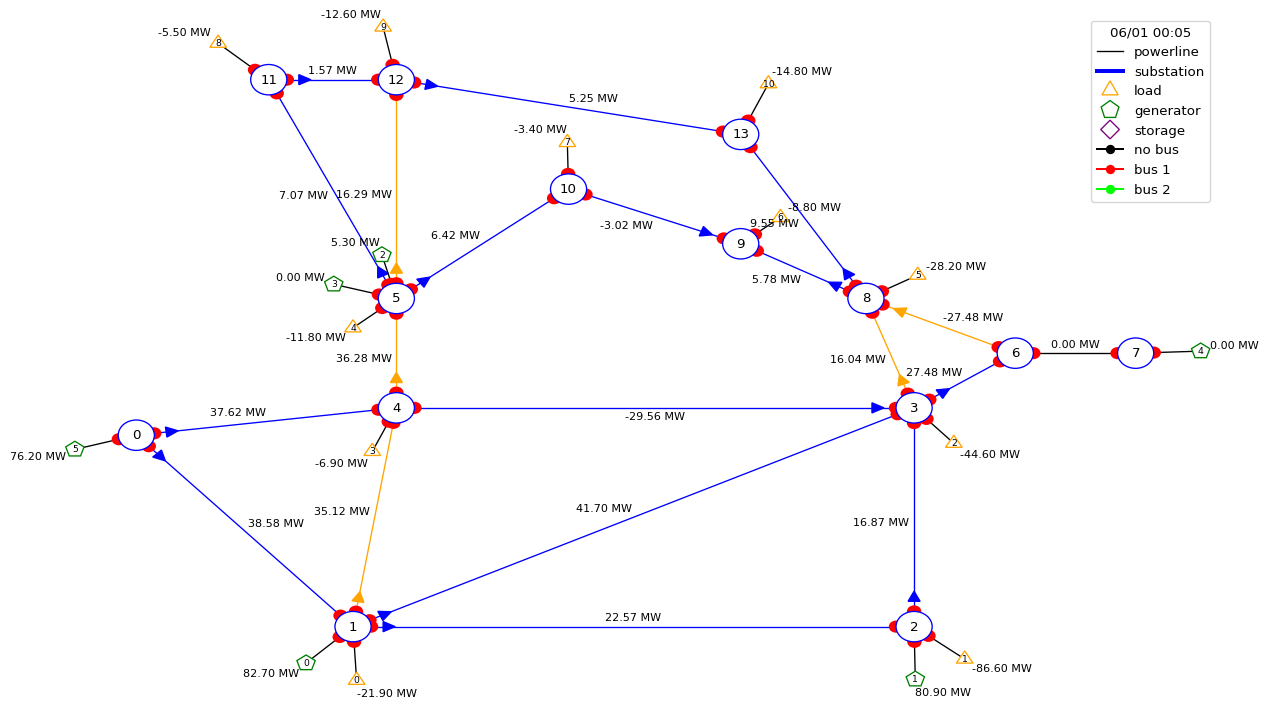

In [144]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
print("when l1 and l2 are both connected")
print("delta theta l1: "+str(get_delta_theta_line(init_obs,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(init_obs,id_l2)))
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


In [155]:
print("for line l1 with id "+str(id_l1))
print("virtual flow when both lines are connected")
print(1/Req_l1*4.212308)
print("virtual flow when l1 is disconnected")
print(1/Req_l1_line_disco*6.728237)

print("virtual flow when l2 is disconnected")
R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
print(1/R_eq_l2_disconnected[sub_l1_or][sub_l1_ex]*4.253909)

print("virtual flow when l1 and l2 are disconnected")
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
print(1/R_eq_l1_l2_disconnected[sub_l1_or][sub_l1_ex]*6.805065)

for line l1 with id 3
virtual flow when both lines are connected
(63.88831568475228+0j)
virtual flow when l1 is disconnected
(63.88831543977518+0j)
virtual flow when l2 is disconnected
(64.35494505116026+0j)
virtual flow when l1 and l2 are disconnected
(64.35494895879611+0j)


In [157]:
print("for line l2 with id "+str(id_l2))
print("virtual flow when both lines are connected")
print(1/Req_l2*0.7317629)
print("virtual flow when l1 is disconnected")
R_eq_l1_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1])
print(1/R_eq_l1_disconnected[sub_l2_or][sub_l2_ex]*0.8447714)

print("virtual flow when l2 is disconnected")
#R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
print(1/Req_l2_line_disco*2.793995)

print("virtual flow when l1 and l2 are disconnected")
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
print(1/R_eq_l1_l2_disconnected[sub_l2_or][sub_l2_ex]*3.2304087)

for line l2 with id 7
virtual flow when both lines are connected
(4.984523846744273+0j)
virtual flow when l1 is disconnected
(5.751187348301629+0j)
virtual flow when l2 is disconnected
(4.984523589926887+0j)
virtual flow when l1 and l2 are disconnected
(5.751188893577116+0j)


when l1 and l2 are disconnected
3
delta theta l1: 6.805065
7
delta theta l1: 3.2304087


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/2986498964.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


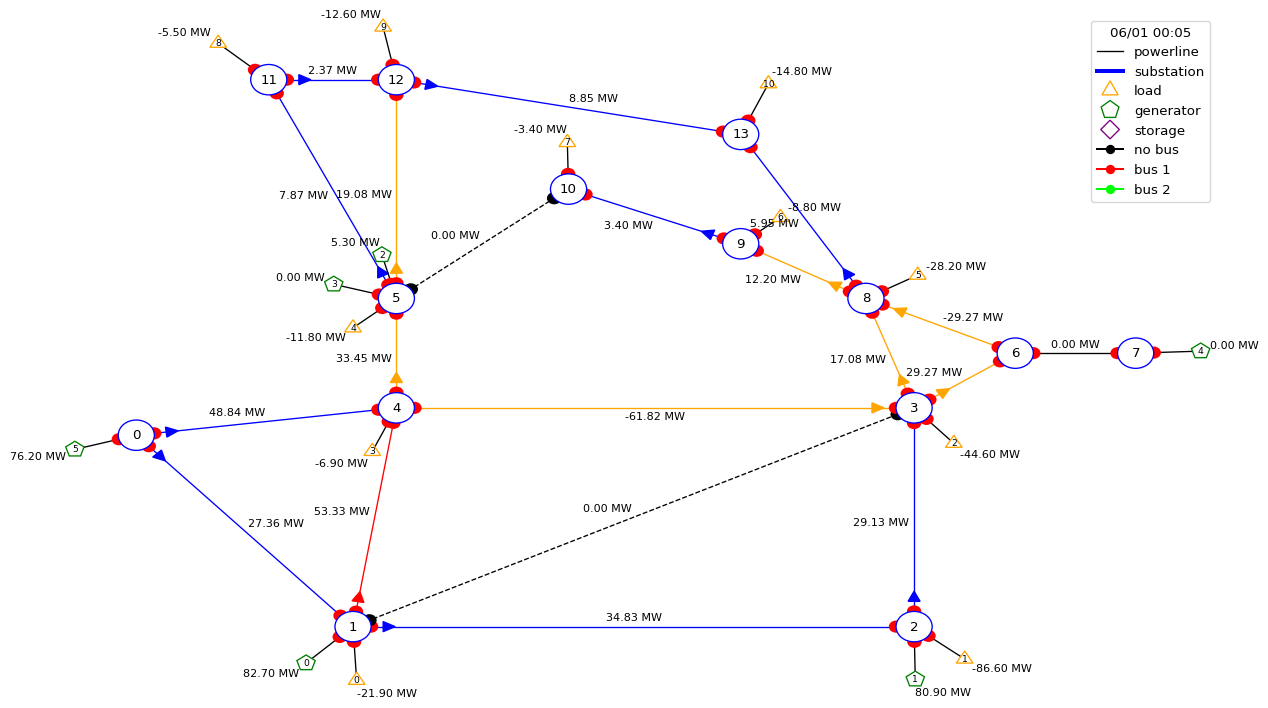

In [141]:
print("when l1 and l2 are disconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info="p")
fig.show()


when l1 is reconnected
3
delta theta l1: 4.253909
7
delta theta l1: 2.793995


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/1486352159.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


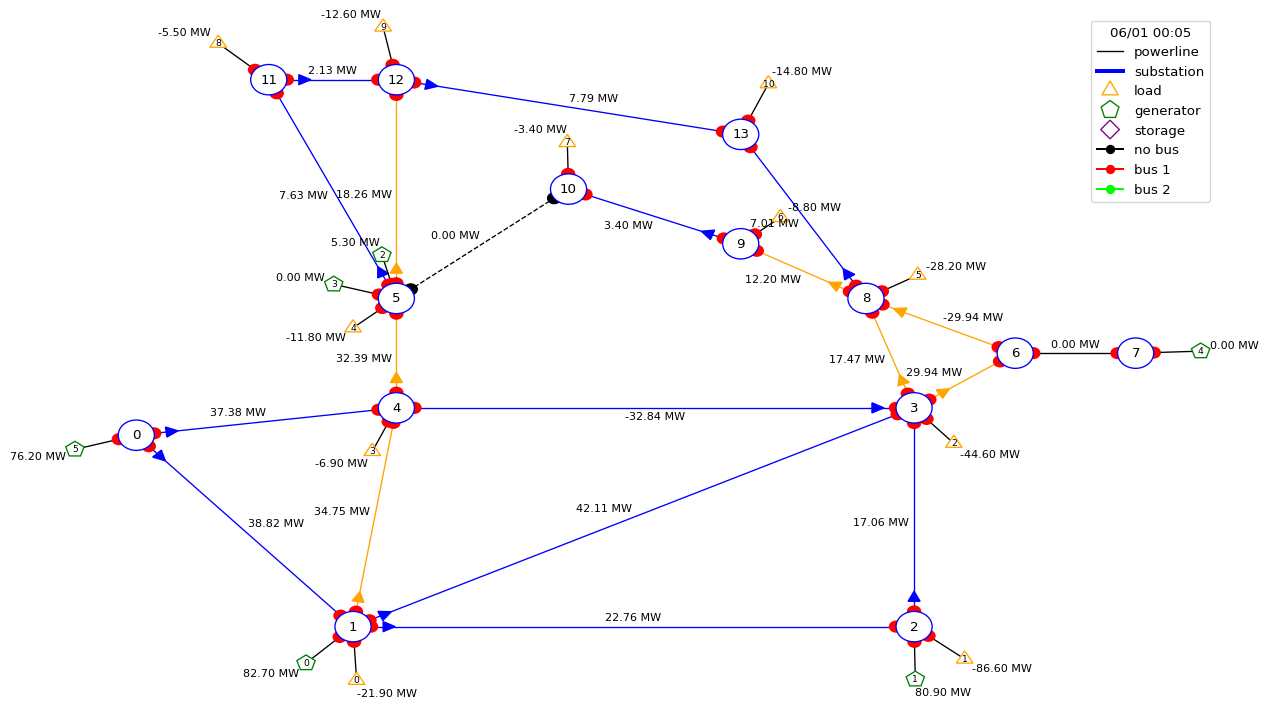

In [142]:
print("when l1 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l2,line_info="p")
fig.show()


when l2 is reconnected
3
delta theta l1: 6.728237
7
delta theta l1: 0.8447714


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_11863/2728517373.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


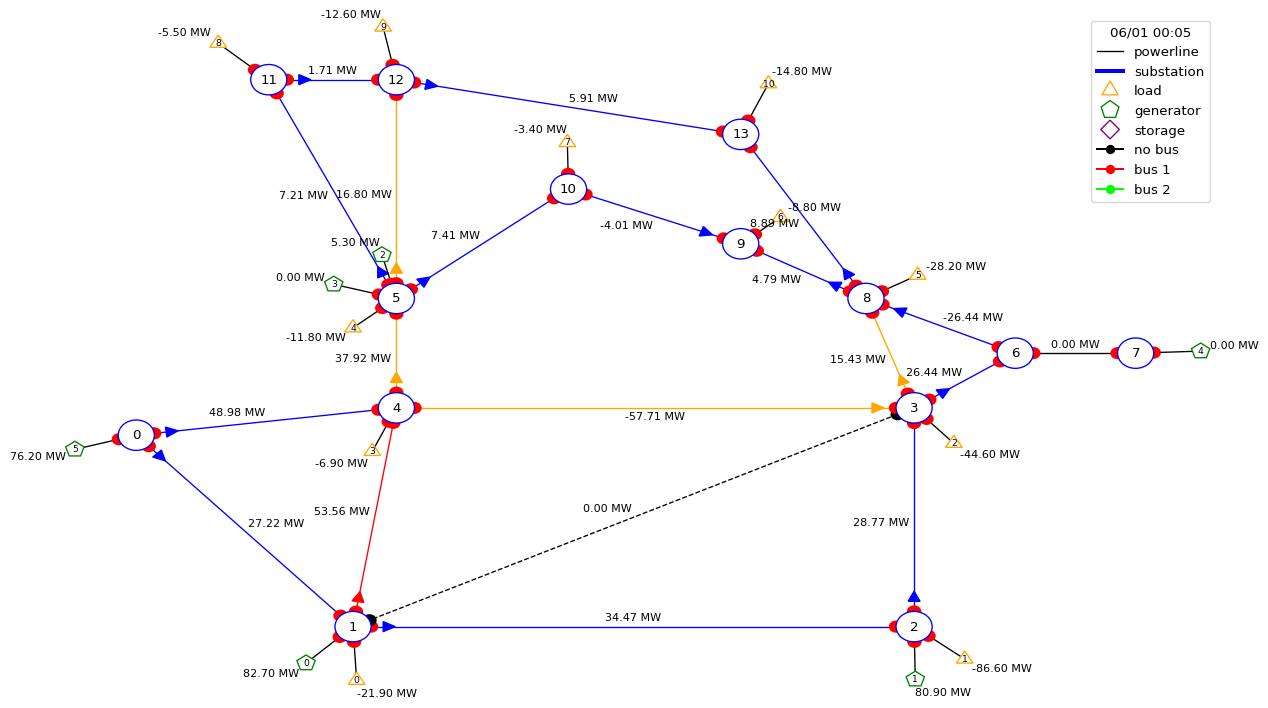

In [143]:
print("when l2 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l1,line_info="p")
fig.show()


### Scenario 3: disconnecting 3 lines and assessing virtual flow l1, l2, l3 (id=3 and id=7 and id=0)

#### computing virtual flows

In [63]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[31.48895452  7.69634534 30.28299473]


In [64]:


obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l3.p_or

array([  0.       ,  76.2      ,  26.675291 ,   0.       ,  34.124706 ,
        20.975294 , -69.69147  ,   0.       ,   7.9306   ,  19.302643 ,
        12.2      ,   5.666758 ,   3.4      ,   2.4306002,   9.133243 ,
        29.08973  ,  16.97703  ,  33.733242 ,   0.       , -29.08973  ],
      dtype=float32)

In [65]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [66]:
theta_or=obs_disconnected_l1_l2_l3.theta_or
theta_ex=obs_disconnected_l1_l2_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2_l3.v_or
v_ex=obs_disconnected_l1_l2_l3.v_or

sub_l1_exv=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

sub_l3_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l3]
lines_sub_or_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_ex_id'])
lines_sub_ex_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_ex_id'])


init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
delta_theta_l3=theta_or[1]-theta_or[2]

print(delta_theta_l1)
print(delta_theta_l2)
print(delta_theta_l3)


virtual_flow_l1=get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)#np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))
virtual_flow_l3=get_Virtual_Flows_NK_withReq(delta_theta_l3,Req_l3,R_l3)#np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)
print(virtual_flow_l3)


[  0.         0.        -6.338084   0.        -6.338084  -9.363821
 -11.419252   0.       -14.277535 -14.277535 -16.661572 -16.661572
 -17.252234 -15.439911 -15.71827  -11.419252 -11.419252  -9.737789
 -14.828015 -16.661572]
[  0.        -9.737789  -9.363821   0.        -9.737789 -11.419252
  -9.737789   0.       -15.439911 -15.71827  -17.252234 -17.539446
 -17.626398 -15.71827  -17.539446 -14.828015 -16.661572 -14.277535
 -14.828015 -14.828015]
5.081168
3.3488626
6.338084
(31.488924609641597+0j)
(7.69634085396277+0j)
(30.282969037755336+0j)


In [67]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
#Not [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(31.48895452,2)))

/tmp/ipykernel_170092/3751175641.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(31.48895452,2)))


In [68]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
#Not [25.822326   13.87408542 29.68840426]


assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.69634534,2)))

/tmp/ipykernel_170092/3481480613.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.69634534,2)))


In [69]:
#from above virtual flows computed [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(30.28299473,2)))

/tmp/ipykernel_170092/3583324950.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(30.28299473,2)))


## Computing LODF based on Req


In [54]:
from IPython.display import Image
Image(filename='LODF_with_Req.png') 

#avec bl la conductance de la ligne l (inverse de la résistance), le terme de la ligne electrique l dans Ybus

FileNotFoundError: [Errno 2] No such file or directory: 'LODF_with_Req.png'

In [55]:
ids_l=[3,7] #[3, 7, 0]

In [150]:
def compute_Req_disconnected(YBus,obs,ids_l):
    YBus_disconnected=YBus.copy()
    for il in ids_l:
        sub_li_ex=obs.line_ex_to_subid[il]
        sub_li_or=obs.line_or_to_subid[il]
        YBus_disconnected[sub_li_or,sub_li_or]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_ex,sub_li_ex]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_or,sub_li_ex]=0
        YBus_disconnected[sub_li_ex,sub_li_or]=0
    
    pinv_Bbus_disconnected=np.linalg.pinv(YBus_disconnected)
    n_nodes=pinv_Bbus_disconnected.shape[0]
    R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

    return R_eq_disconnected

#### R_eq checking

In [57]:
init_obs.line_ex_to_subid

array([ 1,  4,  2,  3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13,  6,  8,
        5,  7,  6], dtype=int32)

In [58]:
init_obs.line_or_to_subid

array([ 0,  0,  1,  1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12,  3,  3,
        4,  6,  8], dtype=int32)

In [59]:
init_obs, *_ = env.simulate(env.action_space())

For line 6-7, the Req is obvious as there is a single path

In [60]:
ids_l=[18]#disconnecting line 0->1
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
x=0,1
y=7

i=6
j=7

#should be the same
print(R_eq[i,j])
print(-1/YBus[i,j])#-1/Bbus_pp[x,y]

#should be the same
print(R_eq_disconnected[x,i])
print(R_eq[x,i])


(0.17614999999999983+0j)
(0.17614999999999997-0j)
[0.22116744+0.j 0.19297365+0.j]
[0.22116744+0.j 0.19297365+0.j]


For line 0-4, if deleting line 0-1, the Req is obvious as there is a single path (and conversely)

In [61]:
ids_l=[0]#disconnecting line 0->1
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
x=0
y=4

i=0
j=1

print(R_eq_disconnected[x,y])
print(-1/YBus[x,y])#-1/Bbus_pp[x,y]

(0.2230399999999998+0j)
(0.22304000000000002-0j)


In [62]:
ids_l=[1]#disconnecting line 0->4
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

x=0
y=1

i=0
j=4

print(R_eq_disconnected[x,y])
print(-1/YBus[x,y])

(0.05917+0j)
(0.05917-0j)


if deleting line 4-5, the Req is the sum of Req_3 + Req_3-8+Req_8

In [63]:
ids_l=[17]#disconnecting line 4->5
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

#x=0
#y=10

i=4
j=5

print(R_eq_disconnected[4,3]+R_eq_disconnected[3,8]+R_eq_disconnected[8,5])
print(R_eq_disconnected[4,5])



(0.5204506559185905+0j)
(0.52045065591859+0j)


In [64]:
#And not true when line 4->5 is connected
print(R_eq[4,3]+R_eq[3,8]+R_eq[8,5])
print(R_eq[4,5])

(0.35802296829730385+0j)
(0.16184222873853774+0j)


if deleting lines 0-1 & 4-5, the Req is the sum of Req_0_1+Req_3 + Req_3-8+Req_8

In [65]:
#combining line disconnections 
ids_l=[0,17]
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

print(-1/YBus[0,4]+R_eq_disconnected[4,3]+R_eq_disconnected[3,8]+R_eq_disconnected[8,5])
print(R_eq_disconnected[0,5])


(0.7447938756633274+0j)
(0.7447938756633268+0j)


### compute_incremental_req

In [81]:

Image(filename='Req_incr_calculation.png')

In [66]:

#avec bl la conductance de la ligne l (inverse de la résistance), le terme de la ligne electrique l dans Ybus
def compute_incremental_req(Reqs_matrix,sub_or,sub_ex,l_connect_or,l_connect_ex,r_l_connect):
    #computing the incremental change in Req at node extremities sub_or & sub_ex 
    #for connection of line with extremities l_connect_or & l_connect_ex 
    Req_or_ex=Reqs_matrix[sub_or,sub_ex]
    #print(Req_or_ex)
    if set([sub_or,sub_ex])==set([l_connect_or,l_connect_ex]):
        Req_or_ex=(Req_or_ex*r_l_connect)/(r_l_connect+Req_or_ex)
    else:
        Req_or_ex=Req_or_ex-((Reqs_matrix[sub_or,l_connect_ex]-Reqs_matrix[sub_or,l_connect_or])-(Reqs_matrix[l_connect_ex,sub_ex]-Reqs_matrix[l_connect_or,sub_ex]))**2/4/(r_l_connect+Reqs_matrix[l_connect_ex,l_connect_or])
    return Req_or_ex

testing one line disconnection 4-5 and reconnection and watching this line req 

In [67]:
ids_l=[17]#disconnecting line 4->5
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
r_l_connect=np.abs(1/YBus[4,5])

R_eq_reconnected_4_5=compute_incremental_req(R_eq_disconnected,4,5,4,5,r_l_connect)

print(R_eq_disconnected[4,5])
print(R_eq[4,5])
print(R_eq_reconnected_4_5)

(0.52045065591859+0j)
(0.16184222873853774+0j)
(0.16184222873853774+0j)


testing two line disconnections 0-1 & 4-5 and reconnection of 0-1 and checking the req 4-5 

In [68]:
ids_l=[0,17]
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
r_l_connect=np.abs(1/YBus[0,1])

Req_4_5_l_0_1_reconnected=compute_incremental_req(R_eq_disconnected,4,5,0,1,r_l_connect)

Req_4_3_l_0_1_reconnected=compute_incremental_req(R_eq_disconnected,4,3,0,1,r_l_connect)
Req_3_8_l_0_1_reconnected=compute_incremental_req(R_eq_disconnected,3,8,0,1,r_l_connect)
Req_5_8_l_0_1_reconnected=compute_incremental_req(R_eq_disconnected,5,8,0,1,r_l_connect)

print(Req_4_5_l_0_1_reconnected)
print(Req_4_3_l_0_1_reconnected+Req_3_8_l_0_1_reconnected+Req_5_8_l_0_1_reconnected)

(0.5204506559185899+0j)
(0.5204506559185902+0j)


testing for a given line disconnection all Req coefficient

In [69]:
ids_l=[7] #[3, 7, 0]
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

sub_li_or=init_obs.line_or_to_subid[ids_l[0]]
sub_li_ex=init_obs.line_ex_to_subid[ids_l[0]]

r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 

In [70]:
for  l in range(0,env.n_line):
    print("line disconnected "+str(l))
    ids_l=[l]
    R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
    sub_li_or=init_obs.line_or_to_subid[ids_l[0]]
    sub_li_ex=init_obs.line_ex_to_subid[ids_l[0]]
    r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
    
    if(l!=18): #because this creates a non-connex grid if disconnecting line 6->7
        for i in range(n_nodes):
            for j in range(n_nodes):
                #if l!=18 and i!=0 and j!=3:
                R_eq_or_ex=compute_incremental_req(R_eq_disconnected,i,j,sub_li_or
                                    ,sub_li_ex,r_line)
                Req_ref_or_ex=R_eq[i,j]
                print([i,j])
                print(R_eq_disconnected[i,j])
                print(Req_ref_or_ex)
                print(R_eq_or_ex)
                assert(np.round(Req_ref_or_ex,3)==np.round(R_eq_or_ex,3))

line disconnected 0
[0, 0]
0j
0j
(-8.435754149307344e-33+0j)
[0, 1]
(0.30611896604610006+0j)
(0.04958556349786339+0j)
(0.04958556349786334+0j)
[0, 2]
(0.35306079411295815+0j)
(0.1494926694064759+0j)
(0.14949266940647568+0j)
[0, 3]
(0.2580695423383157+0j)
(0.09533367899497222+0j)
(0.09533367899497217+0j)
[0, 4]
(0.2230399999999998+0j)
(0.0868550992118338+0j)
(0.08685509921183374+0j)
[0, 5]
(0.3850080324820116+0j)
(0.2404190261139308+0j)
(0.24041902611393076+0j)
[0, 6]
(0.37896563742334516+0j)
(0.22116743782191184+0j)
(0.2211674378219118+0j)
[0, 7]
(0.555115637423345+0j)
(0.3973174378219116+0j)
(0.3973174378219117+0j)
[0, 8]
(0.3852177972641706+0j)
(0.2300440815204234+0j)
(0.23004408152042333+0j)
[0, 9]
(0.42865528846191864+0j)
(0.2753899929200211+0j)
(0.27538999292002087+0j)
[0, 10]
(0.4574855201457359+0j)
(0.30851417338001363+0j)
(0.3085141733800134+0j)
[0, 11]
(0.5117106687623949+0j)
(0.366298862296074+0j)
(0.3662988622960744+0j)
[0, 12]
(0.45055997370501877+0j)
(0.304503638527982+0j)

[13, 4]
(0.4464730939775363+0j)
(0.28877006248548104+0j)
(0.2887700624854812+0j)
[13, 5]
(0.5064905747548958+0j)
(0.2381001381213335+0j)
(0.23810013812133335+0j)
[13, 6]
(0.3611005360613135+0j)
(0.26355131515322483+0j)
(0.26355131515322483+0j)
[13, 7]
(0.537250536061313+0j)
(0.4397013151532245+0j)
(0.4397013151532245+0j)
[13, 8]
(0.27037999999999984+0j)
(0.1938955006490023+0j)
(0.1938955006490023+0j)
[13, 9]
(0.34732007110087687+0j)
(0.24525358747136197+0j)
(0.24525358747136194+0j)
[13, 10]
(0.46596316395514065+0j)
(0.29204354939229976+0j)
(0.2920435493922996+0j)
[13, 11]
(0.6506227194405398+0j)
(0.3185758658868756+0j)
(0.3185758658868753+0j)
[13, 12]
(0.6077990877933286+0j)
(0.22130363500291536+0j)
(0.22130363500291525+0j)
[13, 13]
0j
0j
(-3.223923805637443e-33+0j)
line disconnected 15
[0, 0]
0j
0j
(-2.566286169009293e-31+0j)
[0, 1]
(0.04959069109390554+0j)
(0.04958556349786339+0j)
(0.04958556349786356+0j)
[0, 2]
(0.14956818381503978+0j)
(0.1494926694064759+0j)
(0.14949266940647585+0j

testing two lines reconnections

In [71]:
ids_l=[0,17]
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
r_l_connect=[np.abs(1/YBus[0,1]),np.abs(1/YBus[4,5])]

R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[ids_l[1]])


In [72]:
#reconnecting line 1 
sub_l1_or=0
sub_l1_ex=1

for x in range(n_nodes):
        for y in range(n_nodes):
                R_eq_or_ex=compute_incremental_req(R_eq_disconnected,x,y,sub_l1_or
                                    ,sub_l1_ex,r_l_connect[0])
                Req_ref_or_ex=R_eq[x,y]
                print([x,y])
                print(R_eq_disconnected[x,y])
                print(Req_ref_or_ex)
                print(R_eq_or_ex)
                assert(np.round(R_eq_or_ex,3)==np.round(R_eq_l2_disconnected[x,y],3))
                

[0, 0]
0j
0j
(-5.389583698487359e-31+0j)
[0, 1]
(0.30674921999579097+0j)
(0.04958556349786339+0j)
(0.04960207159208453+0j)
[0, 2]
(0.35424048874764913+0j)
(0.1494926694064759+0j)
(0.14973578508123386+0j)
[0, 3]
(0.2598614447445704+0j)
(0.09533367899497222+0j)
(0.09598660504551823+0j)
[0, 4]
(0.22303999999999954+0j)
(0.0868550992118338+0j)
(0.08708966210692079+0j)
[0, 5]
(0.7447938756633268+0j)
(0.2404190261139308+0j)
(0.5809190359642744+0j)
[0, 6]
(0.41537114135129044+0j)
(0.22116743782191184+0j)
(0.25149630165223824+0j)
[0, 7]
(0.5915211413512904+0j)
(0.3973174378219116+0j)
(0.42764630165223816+0j)
[0, 8]
(0.4584769757515065+0j)
(0.2300440815204234+0j)
(0.2946021360524542+0j)
[0, 9]
(0.5370027635964969+0j)
(0.2753899929200211+0j)
(0.37312792389744465+0j)
[0, 10]
(0.6710473605764126+0j)
(0.30851417338001363+0j)
(0.5071725208773603+0j)
[0, 11]
(0.8409702962767005+0j)
(0.366298862296074+0j)
(0.6770954565776481+0j)
[0, 12]
(0.7569092422053267+0j)
(0.304503638527982+0j)
(0.5930344025062745

In [73]:
#reconnecting two lines
ids_l=[0,3,7]
R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)
R_eq_reconnected=R_eq_disconnected.copy()
for  l in ids_l:
    print("line disconnected "+str(l))
    sub_li_or=init_obs.line_or_to_subid[l]
    sub_li_ex=init_obs.line_ex_to_subid[l]
    r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
    
    for x in range(n_nodes):
        for y in range(n_nodes):
                R_eq_reconnected[x,y]=compute_incremental_req(R_eq_disconnected,x,y,sub_li_or
                                    ,sub_li_ex,r_line)
                Req_ref_or_ex=R_eq[x,y]
    R_eq_disconnected=R_eq_reconnected.copy()
                
for x in range(n_nodes):
    for y in range(n_nodes):
        Req_ref_or_ex=R_eq[x,y]
        print([x,y])
        print(R_eq_reconnected[x,y])
        print(Req_ref_or_ex)
        
        assert(np.round(Req_ref_or_ex,3)==np.round(R_eq_reconnected[x,y],3))
    

line disconnected 0
line disconnected 3
line disconnected 7
[0, 0]
(-2.5962805677516587e-31+0j)
0j
[0, 1]
(0.049585563497863326+0j)
(0.04958556349786339+0j)
[0, 2]
(0.14949266940647538+0j)
(0.1494926694064759+0j)
[0, 3]
(0.09533367899497198+0j)
(0.09533367899497222+0j)
[0, 4]
(0.0868550992118336+0j)
(0.0868550992118338+0j)
[0, 5]
(0.24041902611393065+0j)
(0.2404190261139308+0j)
[0, 6]
(0.22116743782191153+0j)
(0.22116743782191184+0j)
[0, 7]
(0.3973174378219114+0j)
(0.3973174378219116+0j)
[0, 8]
(0.23004408152042333+0j)
(0.2300440815204234+0j)
[0, 9]
(0.2753899929200209+0j)
(0.2753899929200211+0j)
[0, 10]
(0.3085141733800135+0j)
(0.30851417338001363+0j)
[0, 11]
(0.3662988622960737+0j)
(0.366298862296074+0j)
[0, 12]
(0.30450363852798185+0j)
(0.304503638527982+0j)
[0, 13]
(0.3610468002392941+0j)
(0.3610468002392942+0j)
[1, 0]
(0.04958556349786334+0j)
(0.04958556349786333+0j)
[1, 1]
(-1.292308432352966e-31+0j)
0j
[1, 2]
(0.11073603992480463+0j)
(0.11073603992480494+0j)
[1, 3]
(0.0659323689

In [74]:
R_eq_reconnected[1,3]

(0.06593236892932072+0j)

#### Compute_Req_connected

In [76]:
ids_l=[3, 7,0,17] #[3, 7, 0]

R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

In [77]:
id_lines_or=init_obs.line_or_to_subid[ids_l]
id_lines_ex=init_obs.line_ex_to_subid[ids_l]
r_lines=[np.abs(1/YBus[id_line_or,id_line_ex]) for id_line_or,id_line_ex in zip(id_lines_or,id_lines_ex)]
r_lines

[0.17632, 0.1989, 0.05917, 0.23488264000000003]

In [78]:
def Compute_Req_connected(Req_disco,ids_l,r_lines,init_obs):
    
    n_lines=len(id_lines_ex)
    #Reqs_sub_matrix=np.matrix([[Req_disconnected[id_lines_or[i],id_lines_ex[j]] for i in range(n_lines)]
    #                 for j in range(n_lines)])
    #we will connect lines one by one and update Req accordinglly
    Req_disconnected=Req_disco.copy()
    for l,r_l in zip(ids_l,r_lines):
        print("new line connection "+str(l))
        count_changes=0
        sub_li_or=init_obs.line_or_to_subid[l]
        sub_li_ex=init_obs.line_ex_to_subid[l]
        #r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
        
        pairs_l=[]
        #pairs_l_i=[]
        #pairs_l_j=[]
        for l1 in ids_l:
            x1=init_obs.line_or_to_subid[l1]
            y1=init_obs.line_ex_to_subid[l1]
            for l2 in ids_l:
                if l2!=l1:
                    x2=init_obs.line_or_to_subid[l2]
                    y2=init_obs.line_ex_to_subid[l2]

                    pairs=[[x1,y2],[y1,y2],[x1,x2],[x2,y1],[x2,y2]]
                    
                    pairs_l+=pairs
                    #pairs_l_i+=[pair[0] for pair in pairs]
                    #pairs_l_j+=[pair[1] for pair in pairs]
                    for pair in pairs:
                        print(pair)
                        Req_disconnected[pair[0],pair[1]]=compute_incremental_req(Req_disco,pair[0],pair[1],sub_li_or
                                        ,sub_li_ex,r_l)
                        Req_disconnected[pair[1],pair[0]]=Req_disconnected[pair[0],pair[1]].copy()
            
            Req_disconnected[x1,y1]=compute_incremental_req(Req_disco,x1,y1,sub_li_or
                                    ,sub_li_ex,r_l)
            Req_disconnected[y1,x1]=Req_disconnected[x1,y1]
            pairs_l+=[[x1,y1],[y1,x1]]
            #pairs_l_i+=[x1,y1]
            #pairs_l_j+=[y1,x1]
        
        pairs_l_i, pairs_l_j = zip(*pairs_l)#creating two list of indices coordinates, for row and column to be accessed in numpy array
        #print(pairs_l)
        #print(pairs_l_i)
        Req_disco[pairs_l_i,pairs_l_j]=Req_disconnected[pairs_l_i,pairs_l_j].copy()#TO DO: make it work to be more efficient
        #Req_disco[pair for pair in pairs]=Req_disconnected[pair for pair in pairs].copy()
        Req_disco=Req_disconnected.copy()
        
    print("finish")
    #print(Req_disconnected[id_lines_or[0],id_lines_ex[0]])
    return Req_disconnected

In [79]:
Req_disconnected_incre=Compute_Req_connected(R_eq_disconnected,ids_l,r_lines,init_obs)

new line connection 3
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3]
[0, 1]
[1, 5]
[3, 5]
[1, 4]
[4, 3]
[4, 5]
[5, 3]
[10, 3]
[5, 1]
[1, 10]
[1, 3]
[5, 1]
[10, 1]
[5, 0]
[0, 10]
[0, 1]
[5, 5]
[10, 5]
[5, 4]
[4, 10]
[4, 5]
[0, 3]
[1, 3]
[0, 1]
[1, 1]
[1, 3]
[0, 10]
[1, 10]
[0, 5]
[5, 1]
[5, 10]
[0, 5]
[1, 5]
[0, 4]
[4, 1]
[4, 5]
[4, 3]
[5, 3]
[4, 1]
[1, 5]
[1, 3]
[4, 10]
[5, 10]
[4, 5]
[5, 5]
[5, 10]
[4, 1]
[5, 1]
[4, 0]
[0, 5]
[0, 1]
new line connection 7
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3]
[0, 1]
[1, 5]
[3, 5]
[1, 4]
[4, 3]
[4, 5]
[5, 3]
[10, 3]
[5, 1]
[1, 10]
[1, 3]
[5, 1]
[10, 1]
[5, 0]
[0, 10]
[0, 1]
[5, 5]
[10, 5]
[5, 4]
[4, 10]
[4, 5]
[0, 3]
[1, 3]
[0, 1]
[1, 1]
[1, 3]
[0, 10]
[1, 10]
[0, 5]
[5, 1]
[5, 10]
[0, 5]
[1, 5]
[0, 4]
[4, 1]
[4, 5]
[4, 3]
[5, 3]
[4, 1]
[1, 5]
[1, 3]
[4, 10]
[5, 10]
[4, 5]
[5, 5]
[5, 10]
[4, 1]
[5, 1]
[4, 0]
[0, 5]
[0, 1]
new line connection 0
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3

In [80]:
print([id_lines_or[0],id_lines_ex[0]])
R_eq_disconnected[id_lines_or[0],id_lines_ex[0]]

[1, 3]


(0.07685581373993439+0j)

In [81]:
Req_disconnected_incre[id_lines_or[0],id_lines_ex[0]]

(0.06593236892932079+0j)

In [82]:
R_eq[id_lines_or[0],id_lines_ex[0]]

(0.0659323689293208+0j)

In [83]:
assert(np.round(Req_disconnected_incre[id_lines_or[0],id_lines_ex[0]],3)==np.round(R_eq[id_lines_or[0],id_lines_ex[0]],3))

In [84]:
for l in ids_l:
    print("new line connection "+str(l))
    sub_li_or=init_obs.line_or_to_subid[l]
    sub_li_ex=init_obs.line_ex_to_subid[l]
    #r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
    
    print([sub_li_or,sub_li_ex])
    print(R_eq_disconnected[sub_li_or,sub_li_ex])
    print(Req_disconnected_incre[sub_li_or,sub_li_ex])
    print(R_eq[sub_li_or,sub_li_ex])
    
    assert(np.round(Req_disconnected_incre[sub_li_or,sub_li_ex],3)==np.round(R_eq[sub_li_or,sub_li_ex],3))
    for l_prime in ids_l:
        x=init_obs.line_or_to_subid[l_prime]
        y=init_obs.line_ex_to_subid[l_prime]
        
        assert(np.round(Req_disconnected_incre[x,y],3)==np.round(R_eq[x,y],3))
        assert(np.round(Req_disconnected_incre[sub_li_or,x],3)==np.round(R_eq[sub_li_or,x],3))
        #print(Req_disconnected_incre[sub_li_or,x])
        #print(R_eq[sub_li_or,x])
        assert(np.round(Req_disconnected_incre[sub_li_or,y],3)==np.round(R_eq[sub_li_or,y],3))
        
        assert(np.round(Req_disconnected_incre[sub_li_ex,x],3)==np.round(R_eq[sub_li_ex,x],3))
        #print(Req_disconnected_incre[sub_li_ex,y])
        #print(R_eq[sub_li_ex,y])
        assert(np.round(Req_disconnected_incre[sub_li_ex,y],3)==np.round(R_eq[sub_li_ex,y],3))


new line connection 3
[1, 3]
(0.07685581373993439+0j)
(0.06593236892932079+0j)
(0.0659323689293208+0j)
new line connection 7
[5, 10]
(0.9962785130384328+0j)
(0.14680698146884455+0j)
(0.1468069814688445+0j)
new line connection 0
[0, 1]
(0.3067492199957912+0j)
(0.04958556349786335+0j)
(0.04958556349786339+0j)
new line connection 17
[4, 5]
(0.9551454887899377+0j)
(0.1618422287385377+0j)
(0.16184222873853774+0j)


# checking that equivalent flow is conserved between extrimity nodes

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_9735/1274652379.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


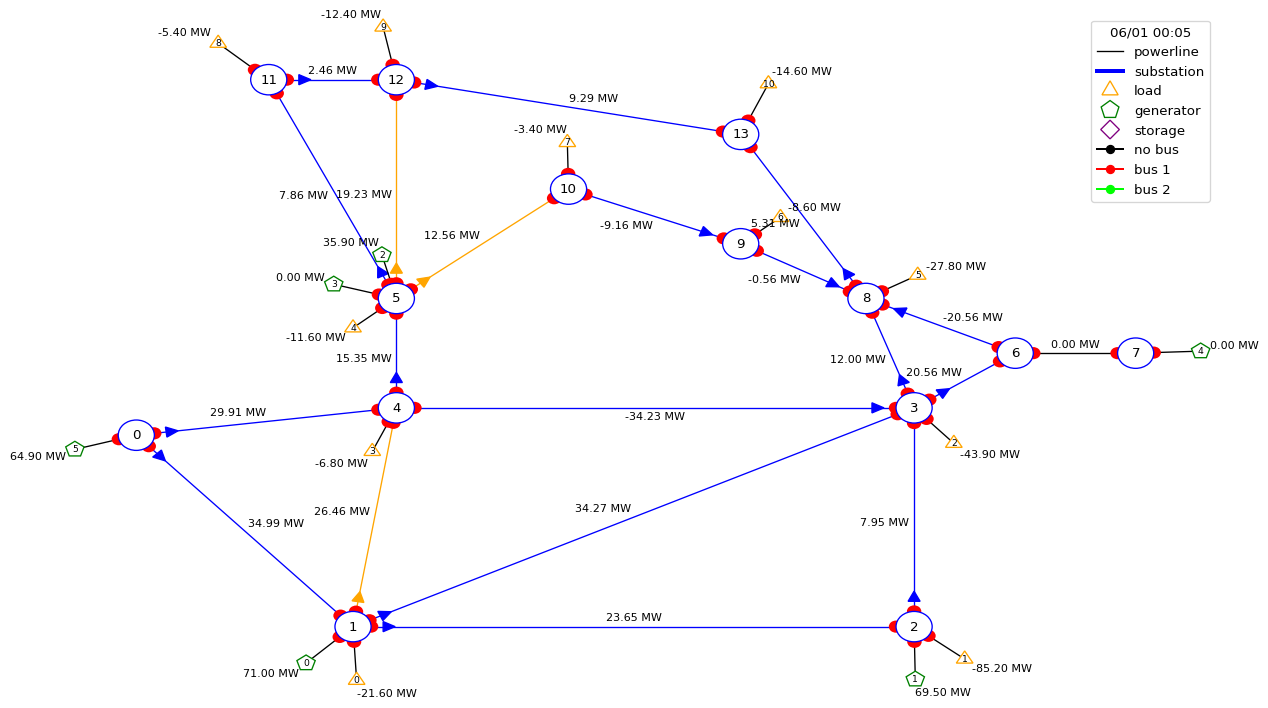

In [97]:
init_obs, *_ = env.simulate(env.action_space())
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()

In [146]:
id_l=17
print(init_obs.p_or[16])

11.997117


### in init state

In [100]:

delta_theta_l=init_obs.theta_or[17]-init_obs.theta_ex[17]


15.346112


In [113]:
init_obs.theta_ex[17]

-5.887805

In [108]:
R_eq[4][5]

(0.16184222873853774+0j)

In [140]:
R_l=np.abs(1/YBus[4,5])
R_l

0.23488264000000003

In [110]:
virtual_Flow=1/R_eq[4][5]*delta_theta_l/360*2*3.14159*100
print(virtual_Flow)

(22.271886883641738+0j)


### when this line is disconnected 

In [117]:
obs_disconnected_l, *_ = env.simulate(env.action_space({"set_line_status": [(17, -1)]}))
print(obs_disconnected_l.p_or[17])

0.0


In [135]:
init_obs.theta_ex[17]

-5.887805

In [136]:
init_obs.theta_or[9]

-5.887805

In [138]:
theta_or=obs_disconnected_l.theta_ex[1]#obs_disconnected_l.theta_or[17] is null there
print(theta_or)
theta_ex=obs_disconnected_l.theta_or[9]
print(theta_ex)

-3.7055223
-10.346922


In [139]:
delta_theta_l_disco=theta_or-theta_ex

In [141]:
Req_l_disco=1/(1/R_eq[4][5]-1/R_l)
print(Req_l_disco)

(0.5204506559185899+0j)


In [142]:
virtual_Flow_disco=1/Req_l_disco*delta_theta_l_disco/360*2*3.14159*100
print(virtual_Flow_disco)

(22.271888209956103+0j)


### when another line is disconnected 

In [170]:
id_other_l=0#16
ids_l=[id_other_l]
obs_disconnected_other_l, *_ = env.simulate(env.action_space({"set_line_status": [(id_other_l, -1)]}))
print(obs_disconnected_other_l.p_or[id_other_l])

0.0


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_9735/540563416.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


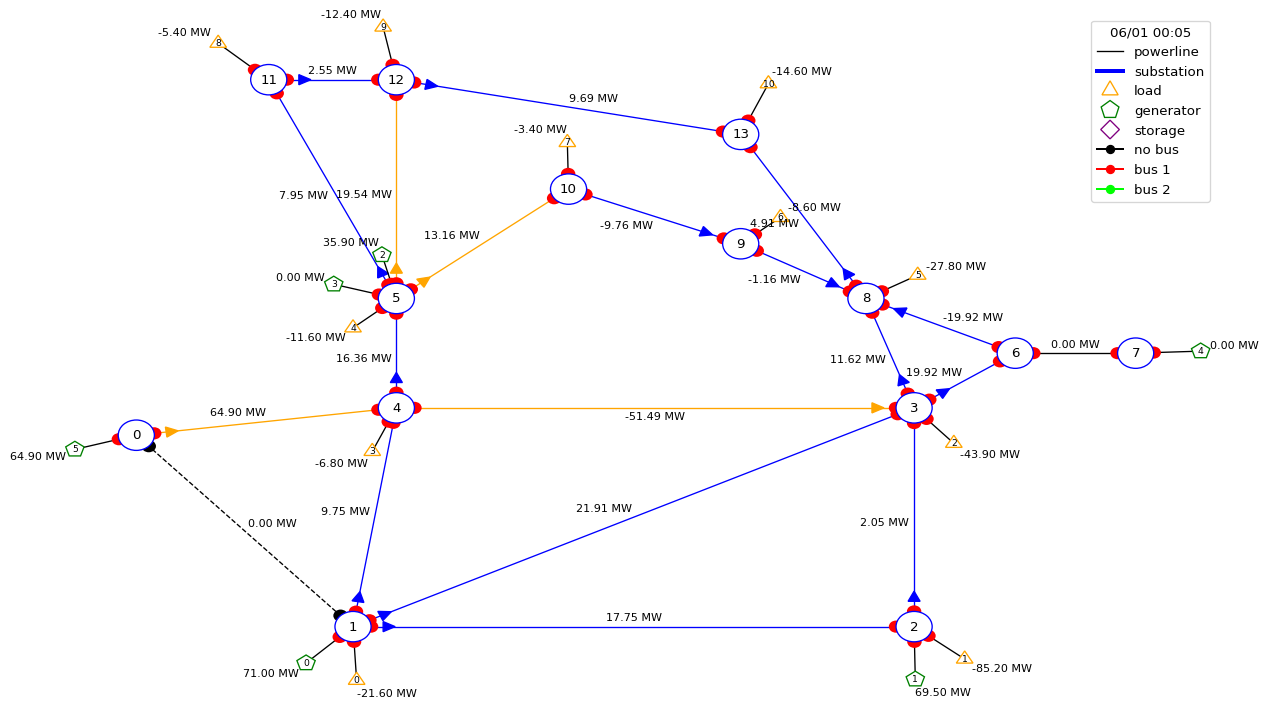

In [171]:
fig = plot_helper.plot_obs(obs_disconnected_other_l,line_info="p")
fig.show()

In [172]:

Req_disconnected_other_l=compute_Req_disconnected(YBus,init_obs,ids_l)
print(Req_disconnected_other_l[4][5])

(0.16196803248201203+0j)


In [173]:

delta_theta_other_l_disco=obs_disconnected_other_l.theta_or[17]-obs_disconnected_other_l.theta_ex[17]
print(delta_theta_other_l_disco)

2.2011414


In [174]:
virtual_Flow_disco_other_l=1/Req_disconnected_other_l[4][5]*delta_theta_other_l_disco/360*2*3.14159*100
print(virtual_Flow_disco_other_l)

(23.718959198634078+0j)


# Important
**Conclusion**: this is true when a line connecting those two extremities is switch on or off.
This can help determine the flow on this line when reconnecting it.
Knowing the flow on this line, we can guess the contribution of the individual line reconnection states, and then compute the updtated power flows.

In [189]:
print(id_l1)
print(id_l2)


3
7


In [177]:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [178]:
obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

In [179]:
obs_disconnected_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [190]:
print(obs_disconnected_l1.p_or[id_l2])
print(init_obs.p_or[id_l2])

beta_l2=init_obs.p_or[id_l2]/obs_disconnected_l1.p_or[id_l2]
beta_l2

13.37023
12.555158


0.9390383

In [192]:
print(obs_disconnected_l2.p_or[id_l1])
print(init_obs.p_or[id_l1])

beta_l1=init_obs.p_or[id_l1]/obs_disconnected_l2.p_or[id_l1]
beta_l1

35.07688
34.271706


0.9770454

In [194]:
beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or

array([ 58.71512 ,  65.63872 ,  54.881897,  34.271706,  64.21604 ,
        24.799389, -93.576904,  12.555158,  16.258156,  40.99601 ,
        10.437847,   4.826949,  -6.040472,   5.911303,  23.147875,
        43.275784,  25.25614 ,  23.248484,   0.      , -43.275784],
      dtype=float32)

In [195]:
init_obs.p_or

array([ 34.98777  ,  29.912228 ,  23.653002 ,  34.271706 ,  26.46306  ,
         7.9530053, -34.229176 ,  12.555158 ,   7.864856 ,  19.226099 ,
        -0.5551573,   5.309045 ,  -9.155158 ,   2.4648554,   9.290956 ,
        20.556768 ,  11.997117 ,  15.346112 ,   0.       , -20.556768 ],
      dtype=float32)

In [196]:
obs_disconnected_l1_l2.p_or

array([ 25.900846 ,  38.99915  ,  34.089565 ,   0.       ,  41.21128  ,
        18.389568 , -64.78417  ,   0.       ,   9.162153 ,  23.764103 ,
        12.       ,  -0.5262569,   3.4      ,   3.7621534,  15.126257 ,
        24.80015  ,  14.473593 ,   8.626256 ,   0.       , -24.80015  ],
      dtype=float32)

In [200]:
1-((1-0.9390383)+(1-0.9770454))

0.9160837

In [197]:
((beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or)-init_obs.p_or)/obs_disconnected_l1_l2.p_or

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_9735/1865617261.py:1: RuntimeWarning: invalid value encountered in true_divide
  ((beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or)-init_obs.p_or)/obs_disconnected_l1_l2.p_or


array([0.9160839 , 0.9160838 , 0.9160837 ,        nan, 0.9160837 ,
       0.9160837 , 0.91608375,        nan, 0.9160838 , 0.9160839 ,
       0.91608375, 0.91608435, 0.9160841 , 0.91608375, 0.9160838 ,
       0.91608375, 0.9160837 , 0.9160836 ,        nan, 0.91608375],
      dtype=float32)

### check this computation for any line connections


In [201]:
ils_connect=[3,7,15]

for i,il in enumerate(ils_connect):
    print(i)
    print(il)

0
3
1
7
2
15


In [252]:
from numpy.testing import assert_almost_equal

def compute_coeff_connections(ils_connect,decimal_Assert=5):
    p_obss_connect=[]
    for il in ils_connect:
        obs_connect_l, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect if ilj!=il]}))
        p_obss_connect.append(obs_connect_l.p_or)
    
    p_obss_connect=np.array(p_obss_connect)
    
    obs_all_disconnected, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect]}))
    p_obs_all_disconnected=obs_all_disconnected.p_or
    
    init_obs, *_ =env.simulate(env.action_space({}))
    p_all_connected=init_obs.p_or
    
    for i,il in enumerate(ils_connect):
        print("line "+str(il))
        print("p final"+str(p_all_connected[il]))
        print("p connected first "+str(p_obss_connect[i][il]))
    betas=np.array([p_all_connected[il]/p_obss_connect[i][il] for i,il in enumerate(ils_connect)])
    
    print(betas)
    #alpha=1-np.sum(1-betas)
    alpha=1-np.sum(betas)
    print(alpha)
                          
    p_all_connected_compute=alpha*p_obs_all_disconnected+np.dot(betas,p_obss_connect)
    #print(np.dot(betas,p_obss_connect))
    
    print(p_all_connected_compute)
    print(p_all_connected)
    
    print("checking if equal with decimal accurary number of "+str(decimal_Assert))
    assert_almost_equal(p_all_connected_compute,p_all_connected,decimal=decimal_Assert)
    return betas
        
        

In [257]:
id_l4=17
ils_connect=[id_l1,id_l2,id_l3,id_l4]#,id_l3]
compute_coeff_connections(ils_connect,decimal_Assert=4)

line 3
p final34.271706
p connected first 23.298422
line 7
p final12.555158
p connected first 3.3140886
line 0
p final34.98777
p connected first 26.167833
line 17
p final15.346112
p connected first 8.898163
[1.4709883 3.7884195 1.3370526 1.7246382]
-7.321098327636719
[ 34.98777    29.912262   23.653015   34.271706   26.463058    7.953003
 -34.229248   12.555158    7.864853   19.226097   -0.5551529   5.30904
  -9.155156    2.4648561   9.290955   20.556763   11.997116   15.346111
   0.        -20.556763 ]
[ 34.98777    29.912228   23.653002   34.271706   26.46306     7.9530053
 -34.229176   12.555158    7.864856   19.226099   -0.5551573   5.309045
  -9.155158    2.4648554   9.290956   20.556768   11.997117   15.346112
   0.        -20.556768 ]
checking if equal with decimal accurary number of 4


array([1.4709883, 3.7884195, 1.3370526, 1.7246382], dtype=float32)

### How to compute incremental change in Req of a connected line when connecting anther line ?
Given that we know Req at each line extremities when connecting them independatly


In [ ]:
Req_l1_no_l2_no_l1=(R1+R3+R4)
Req_l2_no_l2_no_l1=(R2+R3+R5)

Req_l1_no_l2=(R1+R3+R4)//Rl1
Req_l2_no_l1=(R2+R3+R5)//Rl2

### Now computing LODF based on Req

In [85]:
ids_l=[3, 7,0]
obs_disconnected_ids_l, *_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in ids_l]}))

In [86]:
obs_disconnected_ids_l_reconnect=[]
for id_l in ids_l:
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(id_l)
    print(ids_l_reconnect)
    new_obs,*_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in ids_l_reconnect]}))
    obs_disconnected_ids_l_reconnect.append(new_obs)

    

[7, 0]
[3, 0]
[3, 7]


In [87]:
def get_equivalent_delta_theta(obs,sub_or,sub_ex):
    
    lines_sub_or_l3=list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])
    lines_sub_ex_l3=list(obs.get_obj_connect_to(substation_id=sub_l3_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l3_ex)['lines_ex_id'])
    
    theta_or_l=0
    theta_ex_l=0
    
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex
    
    theta_or_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])])
    theta_or_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])])
    
    theta_or_l_sub.remove(0.0)
    if (len(theta_or_l_sub)>=1):
        theta_or_l=np.median(theta_or_l_sub)
        
    theta_ex_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_or_id'])])
    theta_ex_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_ex_id'])])
    
    theta_ex_l_sub.remove(0.0)
    if (len(theta_ex_l_sub)>=1):
        theta_ex_l=np.median(theta_ex_l_sub)
    
    #print(theta_or_l)
    #print(theta_ex_l)
    
    return theta_or_l-theta_ex_l

#### testing virtual flow with deltas and Req

In [88]:
# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)
print(p_end)


[25.01789698 13.64833649 28.66517177]
[-1.0956378e-06  6.4899994e+01  2.6371332e+01  2.7608797e-07
  2.3028677e+01  1.0671335e+01 -7.2230507e+01  3.2992148e-08
  9.2226048e+00  2.3975561e+01  1.1999999e+01 -7.9816353e-01
  3.3999994e+00  3.8226032e+00  1.5398164e+01  2.4628445e+01
  1.4373384e+01  8.8981590e+00  0.0000000e+00 -2.4628445e+01]


In [89]:
theta_or=obs_disconnected_ids_l.theta_or
theta_ex=obs_disconnected_ids_l.theta_ex
virtual_flows_all_disconnected=[]

for j,l_disconnected in enumerate(ids_l):
    
    sub_l_disconnected_ex=obs_disconnected_ids_l.line_ex_to_subid[l_disconnected]
    sub_l_disconnected_or=obs_disconnected_ids_l.line_or_to_subid[l_disconnected]
    r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
    Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
    
    delta_theta_l_j=get_equivalent_delta_theta(obs_disconnected_ids_l,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)#theta_or[l_disconnected]-theta_ex[l_disconnected]
    print("delta theta " +str(delta_theta_l_j))
    
    virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
    virtual_flows_all_disconnected.append(virtual_flow_l)
    print(virtual_flow_l)

delta theta 4.0369754
(25.017871705567995+0j)
delta theta 5.938714
(13.648325474403654+0j)
delta theta 5.9994817
(28.665147316758762+0j)


In [90]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
delta_theta_l3=theta_or[1]-theta_or[2]
print(delta_theta_l1)
print(delta_theta_l2)
print(delta_theta_l3)

4.0369754
5.938714
5.9994817


In [91]:
virtual_flows=[]

#reconnecting line 0 and checking
id_l=0
i=2
ids_l_reconnect=ids_l.copy()
ids_l_reconnect.remove(id_l)
print("reconnecting line: "+str(id_l))

virtual_flows_id_l=[]
obs_i=obs_disconnected_ids_l_reconnect[i].copy()
theta_or=obs_i.theta_or
theta_ex=obs_i.theta_ex

# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,ids_l_reconnect)
print(p_end)

for j,l_disconnected in enumerate(ids_l_reconnect):
    
    sub_l_disconnected_ex=obs_i.line_ex_to_subid[l_disconnected]
    sub_l_disconnected_or=obs_i.line_or_to_subid[l_disconnected]
    r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
    Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
    
    delta_theta_l_j=get_equivalent_delta_theta(obs_i,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)
    print("delta theta " +str(delta_theta_l_j))
    
    virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
    virtual_flows_id_l.append(virtual_flow_l)
    print(virtual_flow_l)
        
# when the last line "0" is reconnected, should find virtual flows as [42.17226227  7.42411841]
# cf cell  in scenario 2
#delat_thetas=[6.805065 3.2304087]

reconnecting line: 0
[35.13046525 13.39065287]
[ 2.5900848e+01  3.8999149e+01  3.4089565e+01 -2.2123956e-08
  4.1211285e+01  1.8389568e+01 -6.4784180e+01 -2.1108352e-07
  9.1621542e+00  2.3764103e+01  1.1999999e+01 -5.2625656e-01
  3.3999999e+00  3.7621534e+00  1.5126257e+01  2.4800148e+01
  1.4473591e+01  8.6262512e+00  0.0000000e+00 -2.4800148e+01]
delta theta 5.6687756
(35.13043458725892+0j)
delta theta 5.8265896
(13.390641591095214+0j)


#### computing delta_virtual_flows for each reconnection

In [92]:
virtual_flows=[]

for i,id_l in enumerate(ids_l):
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(id_l)
    print("reconnecting line: "+str(id_l))
    
    virtual_flows_id_l=[]
    obs_i=obs_disconnected_ids_l_reconnect[i].copy()
    theta_or=obs_i.theta_or
    theta_ex=obs_i.theta_ex
    
    # virtual flows when disconnecting the 3 lines
    init_obs, *_ = env.simulate(env.action_space())
    por_init=init_obs.p_or.copy()
    p_end=get_Virtual_Flows_NK(por_init,A,ids_l_reconnect)
    print(p_end)
    
    for j,l_disconnected in enumerate(ids_l_reconnect):
        
        sub_l_disconnected_ex=obs_i.line_ex_to_subid[l_disconnected]
        sub_l_disconnected_or=obs_i.line_or_to_subid[l_disconnected]
        r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
        Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
        
        delta_theta_l_j=get_equivalent_delta_theta(obs_i,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)
        print("delta theta " +str(delta_theta_l_j))
        
        virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
        virtual_flows_id_l.append(virtual_flow_l)
        print(virtual_flow_l)
        
    virtual_flows.append(virtual_flows_id_l)

reconnecting line: 3
[13.1714998 35.4636845]
[-4.1627192e-07  6.4899994e+01  1.8068716e+01  2.2585001e+01
  8.7462864e+00  2.3687196e+00 -5.8451279e+01  1.0242116e-08
  9.1107435e+00  2.3584265e+01  1.1999999e+01 -2.9500693e-01
  3.3999996e+00  3.7107422e+00  1.4895007e+01  2.4946173e+01
  1.4558814e+01  8.3950014e+00  0.0000000e+00 -2.4946173e+01]
delta theta 5.7312307
(13.171488320510685+0j)
delta theta 7.422377
(35.463652479351076+0j)
reconnecting line: 7
[24.24219365 28.38335668]
[-5.84997508e-07  6.48999939e+01  2.57792931e+01  4.29174349e-07
  2.36207085e+01  1.00792971e+01 -6.45979843e+01  1.36249905e+01
  8.02198601e+00  1.97757454e+01 -1.62498999e+00  4.60226727e+00
 -1.02249908e+01  2.62198544e+00  9.99773216e+00  1.94348946e+01
  1.13423815e+01  1.71227226e+01  0.00000000e+00 -1.94348946e+01]
delta theta 3.911806
(24.242174897793134+0j)
delta theta 5.9404993
(28.383333239918045+0j)
reconnecting line: 0
[35.13046525 13.39065287]
[ 2.5900848e+01  3.8999149e+01  3.4089565e+01 -

In [93]:
delta_virtual_flows=[]
for i in range(len(ids_l)):
    virtual_flows_all_disconnected_reduced=virtual_flows_all_disconnected.copy()
    virtual_flows_all_disconnected_reduced.pop(i)
    
    delta_virtual_flows_id_l=virtual_flows[i]-np.array(virtual_flows_all_disconnected_reduced)
    delta_virtual_flows.append(delta_virtual_flows_id_l)
delta_virtual_flows

[array([-0.47683715+0.j,  6.79850516+0.j]),
 array([-0.77569681+0.j, -0.28181408+0.j]),
 array([10.11256288+0.j, -0.25768388+0.j])]

##### checking consistency of delta_virtual_flows with A LODF matrix

In [94]:
delta_virtual_flows

[array([-0.47683715+0.j,  6.79850516+0.j]),
 array([-0.77569681+0.j, -0.28181408+0.j]),
 array([10.11256288+0.j, -0.25768388+0.j])]

In [95]:
for i,idl in enumerate(ids_l):
    print("new line "+str(idl))
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(idl)
    p_l_connected=virtual_flows_all_disconnected[i]
    for j,idlj in enumerate(ids_l_reconnect):
        p_l_connected+=A[idlj][idl]*delta_virtual_flows[i][j]
    
    print(p_l_connected)
    print(obs_disconnected_ids_l_reconnect[i].p_or[idl])
    assert(np.round(float(p_l_connected),3)==np.round(float(obs_disconnected_ids_l_reconnect[i].p_or[idl]),3))

new line 3
(22.584979158332583+0j)
22.584997
new line 7
(13.62497956055908+0j)
13.62499
new line 0
(25.90082417743226+0j)
25.900846


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_9735/1662038771.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.round(float(p_l_connected),3)==np.round(float(obs_disconnected_ids_l_reconnect[i].p_or[idl]),3))


##### finding LODF now

In [112]:
#pVirtual_l1=por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1)
    
#pVirtual_l1 - por_Lconnected_l1=DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1

#computing the left hand side, b term of the system of linear equations

#we also have 
#pVirtual_l1*LODF1->2-LODF3->2*DeltaPVirtual_l3=DeltaPVirtual_l2
#pVirtual_l1*LODF1->3-LODF2->3*DeltaPVirtual_l2=DeltaPVirtual_l3

#=> linear problem of dimension n_line**2
#COuld be represented as a tensor in n_line dimensions ?
#or solving n_lines problems of dimension n_lines

In [113]:
b=[virtual_flows_all_disconnected[i]-obs_disconnected_ids_l_reconnect[i].p_or[id_l] for i,id_l in enumerate(ids_l)]
b

[(3.062153445701167+0j), (0.013160521778932122+0j), (2.9203133981068987+0j)]

In [114]:
a=[]
#should be changed to solve a problem at a time for LODF of one line
#or can only be coupled as n_line**2 dimensionnal problem

for i in range(len(ids_l)):
    virtual_flows_all_disconnected_reduced=virtual_flows_all_disconnected.copy()
    virtual_flows_all_disconnected_reduced.pop(i)
    
    delta_virtual_flows_id_l=virtual_flows[i]-np.array(virtual_flows_all_disconnected_reduced)
    
    delta_virtual_flows_id_l=np.insert(delta_virtual_flows_id_l,i,0)
    a.append(delta_virtual_flows_id_l)
    
a

[array([ 0.        +0.j, -0.60017457+0.j,  8.55698673+0.j]),
 array([-0.43741784+0.j,  0.        +0.j, -0.15891585+0.j]),
 array([10.68330356+0.j, -0.2722304 +0.j,  0.        +0.j])]

In [1195]:
np.linalg.solve(a,b)

array([ 0.05662719+0.j, -8.50510451-0.j, -0.23868145-0.j])

In [1198]:
delta_virtual_flows_id_l

array([10.68330356+0.j, -0.2722304 +0.j,  0.        +0.j])

In [1199]:

obs_disconnected_ids_l_reconnect[2].p_or[0]

27.362656

In [1200]:
new_obs,*_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in [3,7]]}))
new_obs.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [1201]:
virtual_flows

[[(7.096166288213997+0j), (38.839955764426556+0j)],
 [(31.05150677462484+0j), (30.124053192427766+0j)],
 [(42.17222816901298+0j), (7.42411045889958+0j)]]

In [1202]:
virtual_flows_all_disconnected

[(31.488924609641597+0j), (7.69634085396277+0j), (30.282969037755336+0j)]

In [1203]:
A[3][0]*10.68330356-0.2722304*A[7][0]

-2.920338269648171

In [1204]:
27.362656-30.282969037755336

-2.920313037755335

In [1164]:
ids_l

[3, 7, 0]

In [1167]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[3,7])

[42.17226227  7.42411841]


In [1168]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[3,7,0])

#[-10.68330782   0.27222693]

[31.48895452  7.69634534 30.28299473]


In [1172]:
A[3][0]*-10.68330782 

2.910503164473006